In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer

In [2]:
def count_label_occurences(df, labels, subclasses=None):
    if subclasses:
        count = {label: {subclass: 0 for subclass in subclasses} for label in labels}
    else:
        count = {label: 0 for label in labels}

    for i in range(df.shape[0]):
        data = df.iloc[i]
        for label in labels:
            if subclasses:
                count[label][data[label]] += 1
            elif data[label] == 1:
                count[label] += 1

    return count

In [3]:
# Function to calculate imbalance ratio for a column
def calculate_imbalance_ratio(column):
    value_counts = column.value_counts()
    value_counts.drop('neg_pos', inplace=True, errors='ignore')
        
    max_count = value_counts.max()
    min_count = value_counts.min()

    # print(min_count)
    return max_count / min_count if min_count > 0 else float('inf')

In [4]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def sequence_length_statistics(texts):
    # Tokenize each text and calculate their lengths
    token_lengths = [len(tokenizer.tokenize(text)) for text in texts]
    
    # Calculate the average length
    average_length = sum(token_lengths) / len(token_lengths)
    max_length = max(token_lengths)
    
    print("Average length of tokenized text:", average_length)
    print("Max token length:", max_length)

    counts, bins = np.histogram(token_lengths)
    plt.stairs(counts, bins)
    plt.show()

W0508 20:30:52.351022 70566 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


# CASA

In [232]:
data = pd.read_csv('/kaggle/input/casa-dataset/CASA-combined.csv')

In [233]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [234]:
label_columns = data.columns[1:7]
print(label_columns)

Index(['fuel', 'machine', 'others', 'part', 'price', 'service'], dtype='object')


In [235]:
label_count = count_label_occurences(data, label_columns, subclasses=['positive', 'neutral', 'negative'])
print(label_count)

{'fuel': {'positive': 141, 'neutral': 905, 'negative': 34}, 'machine': {'positive': 177, 'neutral': 844, 'negative': 59}, 'others': {'positive': 291, 'neutral': 718, 'negative': 71}, 'part': {'positive': 203, 'neutral': 769, 'negative': 108}, 'price': {'positive': 118, 'neutral': 905, 'negative': 57}, 'service': {'positive': 81, 'neutral': 923, 'negative': 76}}


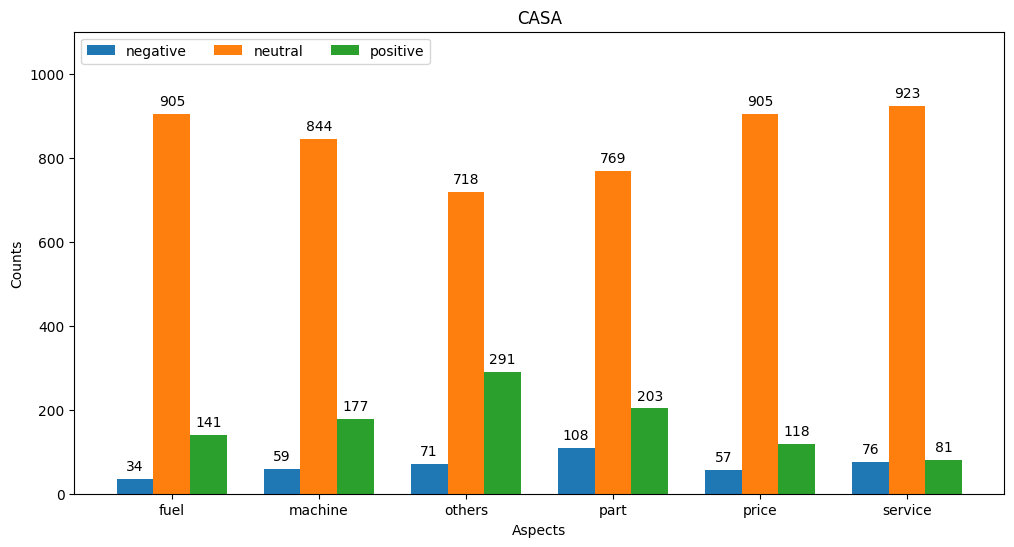

In [236]:
# Plot configuration
x = np.arange(0, 6)
labels = ['fuel', 'machine', 'others', 'part', 'price', 'service']
width = 0.25  # Width of each bar
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6))

counts = {
    'negative': [],
    'neutral': [],
    'positive': [],
}

for i, label in enumerate(label_count.keys()):
    counts['negative'].append(label_count[label]['negative'])
    counts['neutral'].append(label_count[label]['neutral'])
    counts['positive'].append(label_count[label]['positive'])

for attribute, measurement in counts.items():
    # print(attribute)
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('CASA')
ax.set_ylabel('Counts')
ax.set_xlabel('Aspects')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1100)

# Show the chart
plt.show()

In [237]:
# Specify the columns to analyze
columns_to_analyze = ['fuel', 'machine', 'others', 'part', 'price', 'service']

# Calculate imbalance ratios for each column
imbalance_ratios = {col: calculate_imbalance_ratio(data[col]) for col in columns_to_analyze}

# Calculate the mean imbalance ratio
mean_imbalance_ratio = sum(imbalance_ratios.values()) / len(imbalance_ratios)

# Print the results
print("Imbalance Ratios for each column:", imbalance_ratios)
print("Mean Imbalance Ratio:", mean_imbalance_ratio)


Imbalance Ratios for each column: {'fuel': 26.61764705882353, 'machine': 14.305084745762711, 'others': 10.112676056338028, 'part': 7.12037037037037, 'price': 15.87719298245614, 'service': 12.144736842105264}
Mean Imbalance Ratio: 14.362951342642672


Average length of tokenized text: 16.11111111111111
Max token length: 72


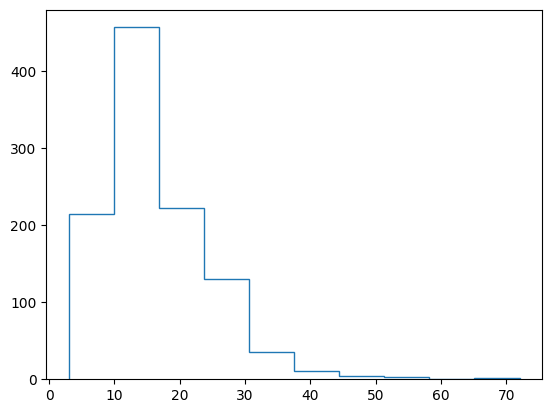

In [238]:
sequence_length_statistics(data['sentence'])

# HoASA

In [239]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv')

data = pd.concat([train_data, val_data, test_data], axis=0)

print(data.shape)

(2854, 11)


In [240]:
data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [241]:
label_columns = data.columns[1:11]
print(label_columns)

Index(['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service',
       'sunrise_meal', 'tv', 'wifi'],
      dtype='object')


In [242]:
label_count = count_label_occurences(data, label_columns, subclasses=['pos', 'neut', 'neg', 'neg_pos'])
print(label_count)

{'ac': {'pos': 66, 'neut': 2273, 'neg': 514, 'neg_pos': 1}, 'air_panas': {'pos': 36, 'neut': 2397, 'neg': 421, 'neg_pos': 0}, 'bau': {'pos': 14, 'neut': 2402, 'neg': 438, 'neg_pos': 0}, 'general': {'pos': 298, 'neut': 2519, 'neg': 37, 'neg_pos': 0}, 'kebersihan': {'pos': 261, 'neut': 1665, 'neg': 922, 'neg_pos': 6}, 'linen': {'pos': 85, 'neut': 2000, 'neg': 768, 'neg_pos': 1}, 'service': {'pos': 315, 'neut': 2067, 'neg': 471, 'neg_pos': 1}, 'sunrise_meal': {'pos': 92, 'neut': 2633, 'neg': 129, 'neg_pos': 0}, 'tv': {'pos': 19, 'neut': 2586, 'neg': 249, 'neg_pos': 0}, 'wifi': {'pos': 28, 'neut': 2422, 'neg': 404, 'neg_pos': 0}}


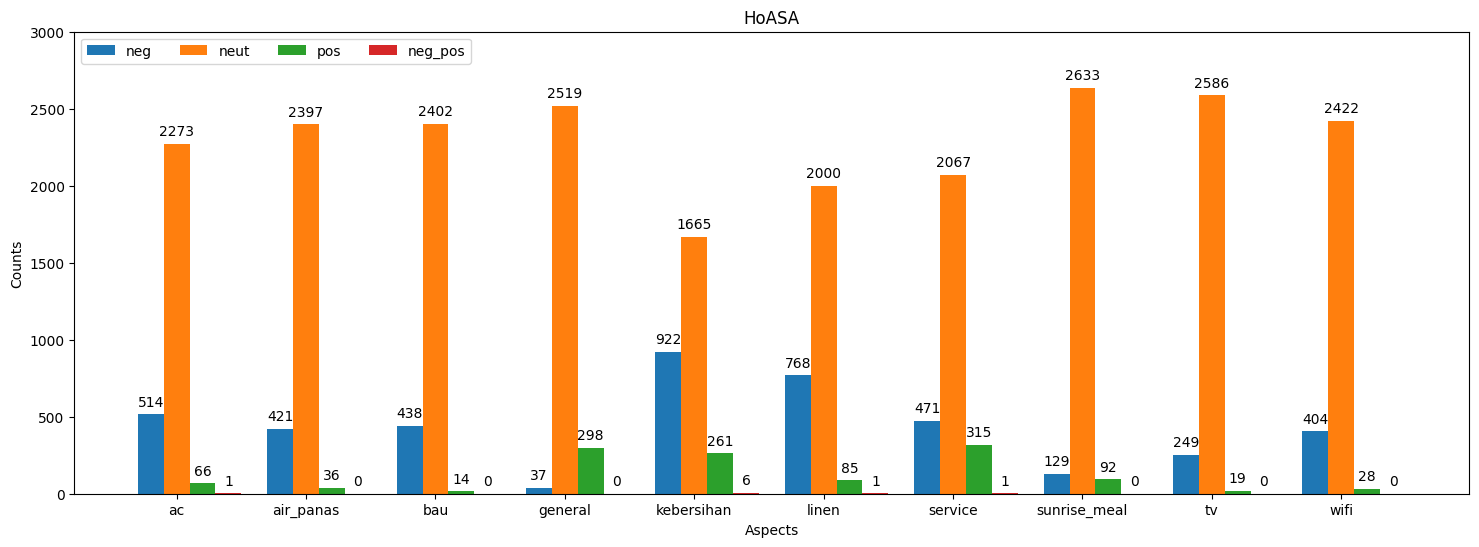

In [243]:
# Plot configuration
x = np.arange(0, 10)
labels = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service',
       'sunrise_meal', 'tv', 'wifi']
width = 0.2  # Width of each bar
multiplier = 0

fig, ax = plt.subplots(figsize=(18, 6))

counts = {
    'neg': [],
    'neut': [],
    'pos': [],
    'neg_pos': [],
}

for i, label in enumerate(label_count.keys()):
    counts['neg'].append(label_count[label]['neg'])
    counts['neg_pos'].append(label_count[label]['neg_pos'])
    counts['neut'].append(label_count[label]['neut'])
    counts['pos'].append(label_count[label]['pos'])    

for attribute, measurement in counts.items():
    # print(attribute)
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('HoASA')
ax.set_ylabel('Counts')
ax.set_xlabel('Aspects')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 3000)

# Show the chart
plt.show()

In [244]:
# Specify the columns to analyze
columns_to_analyze = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service',
       'sunrise_meal', 'tv', 'wifi']

# Calculate imbalance ratios for each column
imbalance_ratios = {col: calculate_imbalance_ratio(data[col]) for col in columns_to_analyze}

# Calculate the mean imbalance ratio
mean_imbalance_ratio = (sum(imbalance_ratios.values()) / len(imbalance_ratios)).round(2)

# Print the results
print("Imbalance Ratios for each column:", imbalance_ratios)
print("Mean Imbalance Ratio:", mean_imbalance_ratio)


Imbalance Ratios for each column: {'ac': 34.43939393939394, 'air_panas': 66.58333333333333, 'bau': 171.57142857142858, 'general': 68.08108108108108, 'kebersihan': 6.379310344827586, 'linen': 23.529411764705884, 'service': 6.561904761904762, 'sunrise_meal': 28.619565217391305, 'tv': 136.10526315789474, 'wifi': 86.5}
Mean Imbalance Ratio: 62.84


Average length of tokenized text: 24.481429572529784
Max token length: 183


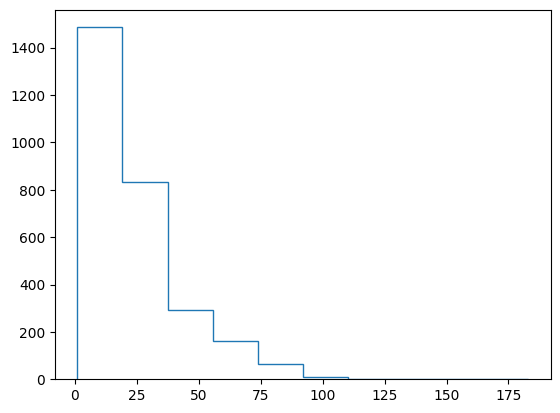

In [245]:
sequence_length_statistics(data['review'])

# Netifier

In [247]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv')
test_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv')

data = pd.concat([train_data, test_data], axis=0)

print(data.shape)

(7773, 7)


In [248]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [249]:
label_columns = data.columns[2:6]
print(label_columns)

Index(['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'], dtype='object')


In [250]:
label_count = count_label_occurences(data, label_columns)
print(label_count)

{'pornografi': 1747, 'sara': 1238, 'radikalisme': 1276, 'pencemaran_nama_baik': 2425}


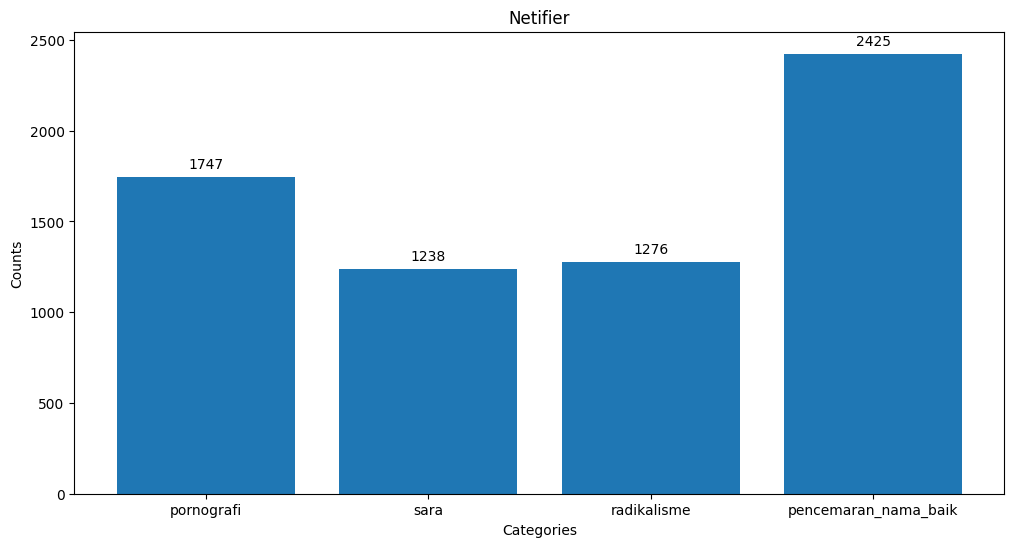

In [251]:
# Plot configuration
x = np.arange(0,4)

fig, ax = plt.subplots(figsize=(12, 6))

rects = ax.bar(x, label_count.values())
ax.bar_label(rects, padding=4)

# Customization
ax.set_xlabel('Categories')
ax.set_ylabel('Counts')
ax.set_title('Netifier')
ax.set_xticks(x)
ax.set_xticklabels(['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'])

# Show the chart
plt.show()

In [252]:
# Specify the columns to analyze
columns_to_analyze = ['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik']

# Calculate imbalance ratios for each column
imbalance_ratios = {col: calculate_imbalance_ratio(data[col]) for col in columns_to_analyze}

# Calculate the mean imbalance ratio
mean_imbalance_ratio = (sum(imbalance_ratios.values()) / len(imbalance_ratios)).round(2)

# Print the results
print("Imbalance Ratios for each column:", imbalance_ratios)
print("Mean Imbalance Ratio:", mean_imbalance_ratio)


Imbalance Ratios for each column: {'pornografi': 3.4493417286777333, 'sara': 5.278675282714055, 'radikalisme': 5.091692789968652, 'pencemaran_nama_baik': 2.205360824742268}
Mean Imbalance Ratio: 4.01


Average length of tokenized text: 54.08812556284575
Max token length: 2591


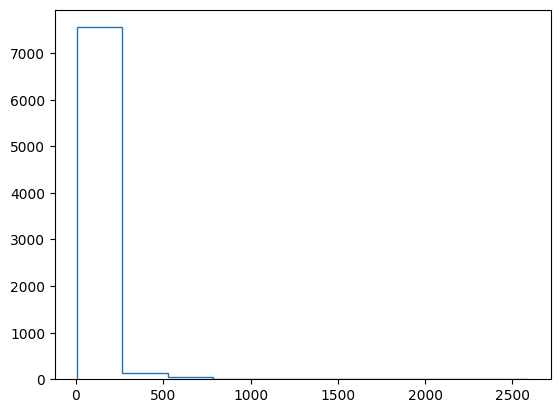

In [253]:
sequence_length_statistics(data['processed_text'])

# HSD

In [7]:
data = pd.read_csv('../../dataset/id-multi-label-hate-speech-and-abusive-language-detection/re_dataset.csv', encoding='latin-1')

print(data.shape)

(13169, 13)


In [8]:
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [9]:
label_columns = data.columns[1:13]
print(label_columns)

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')


In [10]:
label_count = count_label_occurences(data, label_columns)
print(label_count)

{'HS': 5561, 'Abusive': 5043, 'HS_Individual': 3575, 'HS_Group': 1986, 'HS_Religion': 793, 'HS_Race': 566, 'HS_Physical': 323, 'HS_Gender': 306, 'HS_Other': 3740, 'HS_Weak': 3383, 'HS_Moderate': 1705, 'HS_Strong': 473}


(13169, 13)
(3328, 13)
(14169, 13)


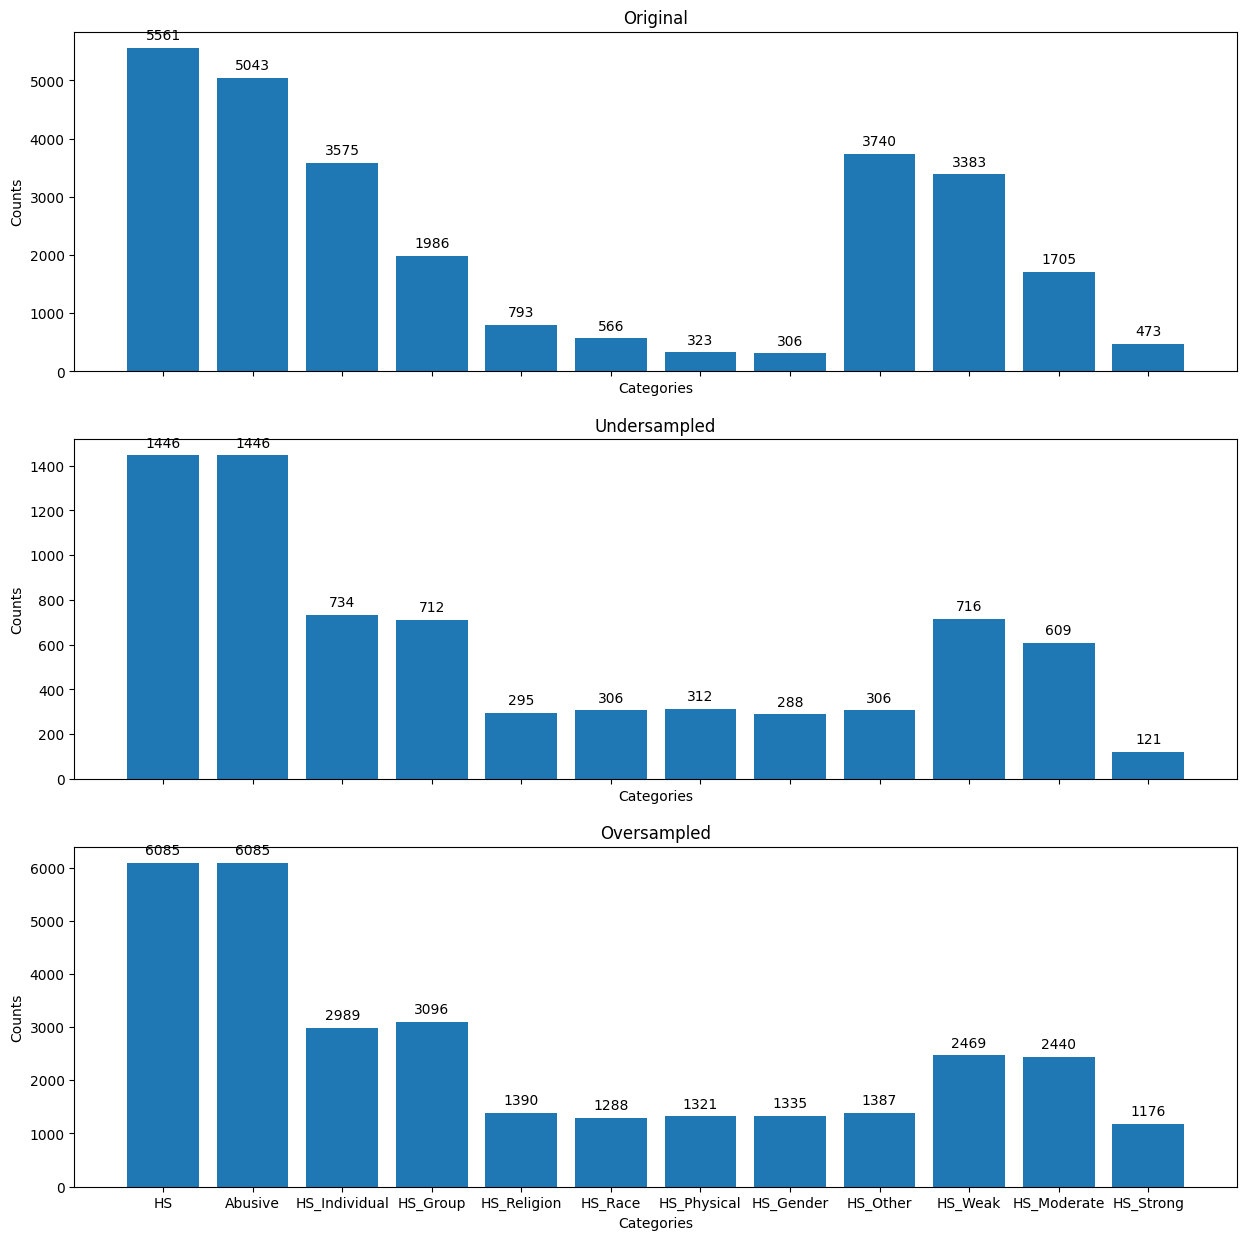

In [ ]:
# Plot configuration
x = np.arange(0,12)

fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
names = ['re_dataset', 'augmented/undersampled', 'augmented/oversampled-2']
titles = ['Original', 'Undersampled', 'Oversampled']

for i in range(3):
       data = pd.read_csv(f'../../dataset/id-multi-label-hate-speech-and-abusive-language-detection/{names[i]}.csv', encoding='latin-1')
       label_columns = data.columns[1:]
       label_count = count_label_occurences(data, label_columns)

       ax = axes[i]  # Get the current subplot

       print(data.shape)

       rects = ax.bar(x, label_count.values())
       ax.bar_label(rects, padding=4)

       # Customization
       ax.set_xlabel('Categories')
       ax.set_ylabel('Counts')
       ax.set_title(titles[i])
       ax.set_xticks(x)
       ax.set_xticklabels(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
              'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
              'HS_Strong'])

# Show the chart
plt.show()

In [259]:
# Specify the columns to analyze
columns_to_analyze = ['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong']

# Calculate imbalance ratios for each column
imbalance_ratios = {col: calculate_imbalance_ratio(data[col]) for col in columns_to_analyze}

# Calculate the mean imbalance ratio
mean_imbalance_ratio = (sum(imbalance_ratios.values()) / len(imbalance_ratios)).round(2)

# Print the results
print("Imbalance Ratios for each column:", imbalance_ratios)
print("Mean Imbalance Ratio:", mean_imbalance_ratio)


Imbalance Ratios for each column: {'HS': 1.368099262722532, 'Abusive': 1.6113424548879636, 'HS_Individual': 2.6836363636363636, 'HS_Group': 5.6309164149043305, 'HS_Religion': 15.60655737704918, 'HS_Race': 22.266784452296818, 'HS_Physical': 39.77089783281734, 'HS_Gender': 42.0359477124183, 'HS_Other': 2.5211229946524063, 'HS_Weak': 2.892698788057937, 'HS_Moderate': 6.7237536656891495, 'HS_Strong': 26.841437632135307}
Mean Imbalance Ratio: 14.16


Average length of tokenized text: 29.17184296453793
Max token length: 357


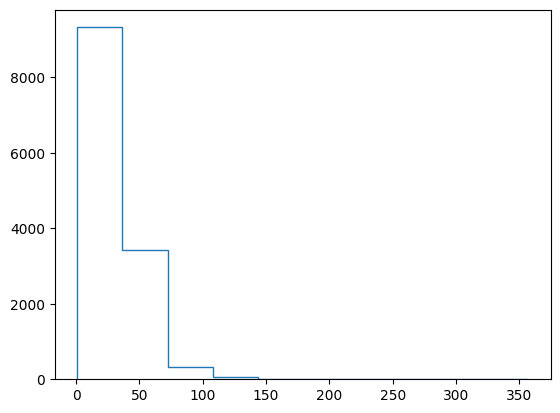

In [260]:
sequence_length_statistics(data['Tweet'])

# Doctor's Answer

In [261]:
data = pd.read_csv('/kaggle/input/doctors-answer-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')

print(data.shape)

(500, 13)


In [262]:
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [263]:
label_columns = data.columns[2:8]
print(label_columns)

Index(['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'], dtype='object')


In [264]:
label_count = count_label_occurences(data, label_columns)
print(label_count)

{'1-FR': 500, '2-GI': 41, '3-PI': 500, '4-DM': 439, '5-EDTRB': 495, '6-RE': 24}


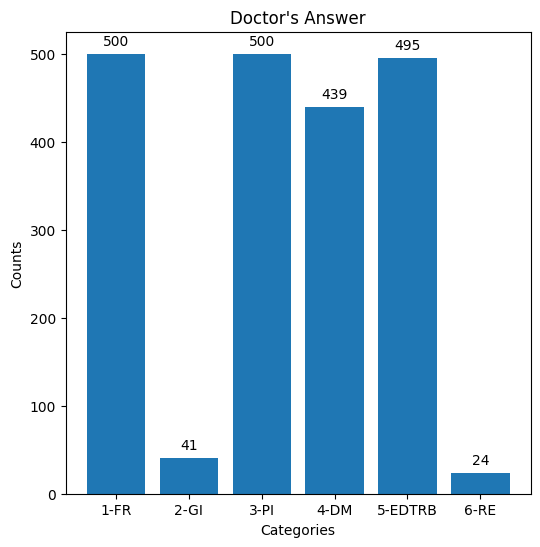

In [265]:
# Plot configuration
x = np.arange(0,6)

fig, ax = plt.subplots(figsize=(6, 6))

rects = ax.bar(x, label_count.values())
ax.bar_label(rects, padding=4)

# Customization
ax.set_xlabel('Categories')
ax.set_ylabel('Counts')
ax.set_title("Doctor's Answer")
ax.set_xticks(x)
ax.set_xticklabels(['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'])

# Show the chart
plt.show()

In [266]:
# Specify the columns to analyze
columns_to_analyze = ['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE']

# Calculate imbalance ratios for each column
imbalance_ratios = {col: calculate_imbalance_ratio(data[col]) for col in columns_to_analyze}

# Calculate the mean imbalance ratio
mean_imbalance_ratio = (sum(imbalance_ratios.values()) / len(imbalance_ratios)).round(2)

# Print the results
print("Imbalance Ratios for each column:", imbalance_ratios)
print("Mean Imbalance Ratio:", mean_imbalance_ratio)


Imbalance Ratios for each column: {'1-FR': 1.0, '2-GI': 11.195121951219512, '3-PI': 1.0, '4-DM': 7.19672131147541, '5-EDTRB': 99.0, '6-RE': 19.833333333333332}
Mean Imbalance Ratio: 23.2


Average length of tokenized text: 130.202
Max token length: 469


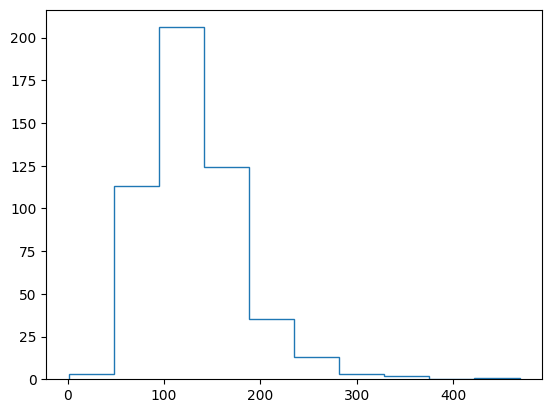

In [267]:
sequence_length_statistics(data['filtered_text'])